In [38]:
import prophet
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import math
import datetime
from sklearn.metrics import mean_absolute_error


In [39]:
def makeDir(dirname):
    if not os.path.exists(dirname):
        os.mkdir(dirname)
    
SCENARIO_FOLDER = 'scenario'    
makeDir(SCENARIO_FOLDER)

In [40]:
TIMESTAMP = 1589500800 # 15.05.2020

In [41]:
year = pd.to_datetime(TIMESTAMP, unit='s').year
month = pd.to_datetime(TIMESTAMP, unit='s').month
day = pd.to_datetime(TIMESTAMP, unit='s').day

In [42]:
def generate(id):
    dfs = []

    for y in ['2019', '2020']:
        for m in ['03', '04', '05']:
            dfs.append(pd.read_csv('background' + '/' +
                       y + '/' + m + '/' + str(id) + '.csv'))

    df = pd.concat(dfs)

    ts = pd.to_datetime(TIMESTAMP, unit='s')
    s = df.rename(columns={'timestamp': 'ds', 'value': 'y'})
    s['ds'] = pd.to_datetime(s['ds'], unit='s')
    s = s.loc[(ts - s['ds'] < pd.Timedelta(3, 'D')) &
              (ts - s['ds'] > pd.Timedelta(1, 's'))]
    s = s[['ds', 'y']]

    m = prophet.Prophet(changepoint_prior_scale=0.1,
                        seasonality_prior_scale=10.0).fit(s)

    future = m.make_future_dataframe(periods=24 * 4, freq='15min')
    fcst = m.predict(future)
    y_hat = fcst['yhat'][-24*4:].values
    s = df.rename(columns={'timestamp': 'ds', 'value': 'y'})
    s['ds'] = pd.to_datetime(s['ds'], unit='s')

    y = s.loc[(s['ds'] - ts < pd.Timedelta(1, 'D')) &
                   (s['ds'] - ts >= pd.Timedelta(0, 's'))]
    y_true = s.loc[(s['ds'] - ts < pd.Timedelta(1, 'D')) &
                   (s['ds'] - ts >= pd.Timedelta(0, 's'))]['y'].values
    y_before = s.loc[(s['ds'] - ts < pd.Timedelta(2, 'D')) &
                     (s['ds'] - ts >= pd.Timedelta(1, 'D'))]['y'].values

    mae = mean_absolute_error(y_true, y_hat)
    print('MAE (3 days learning): %.5f' % mae)
    mae = mean_absolute_error(y_true, y_before)
    print('MAE (day before): %.5f' % mae)

    pred = pd.DataFrame(data={'timestamp': y['ds'].values, 'value': y_hat})
    makeDir(SCENARIO_FOLDER + "/baseline/")
    makeDir(SCENARIO_FOLDER + "/baseline/" + str(year))
    makeDir(SCENARIO_FOLDER + "/baseline/" + str(year) + "/" + f'{month:02d}')
    pred.to_csv(SCENARIO_FOLDER + "/baseline/" + str(year) +
                "/" + f'{month:02d}' + "/" + str(id) + ".csv")

    tru = pd.DataFrame(y_true)
    makeDir(SCENARIO_FOLDER + "/background/")
    makeDir(SCENARIO_FOLDER + "/background/" + str(year))
    makeDir(SCENARIO_FOLDER + "/background/" + str(year) + "/" + f'{month:02d}')
    tru.to_csv(SCENARIO_FOLDER + "/background/" + str(year) +
                "/" + f'{month:02d}' + "/" + str(id) + ".csv")

    plt.figure(figsize=(30, 5))
    plt.plot(pred['value'].values)
    plt.plot(y_true)
    plt.show()


INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


MAE (3 days learning): 54.57055
MAE (day before): 72.86458


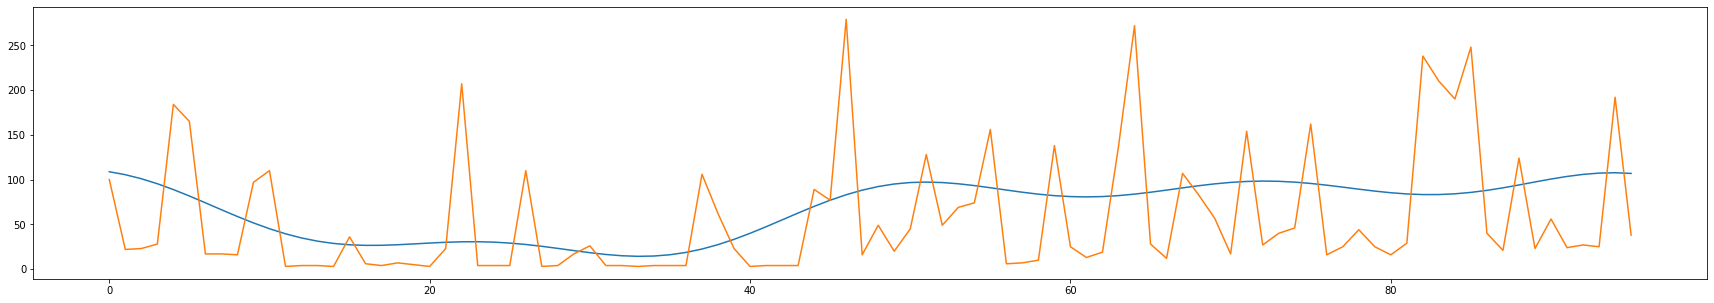

In [43]:
generate(1)

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


MAE (3 days learning): 20.34625
MAE (day before): 64.00000


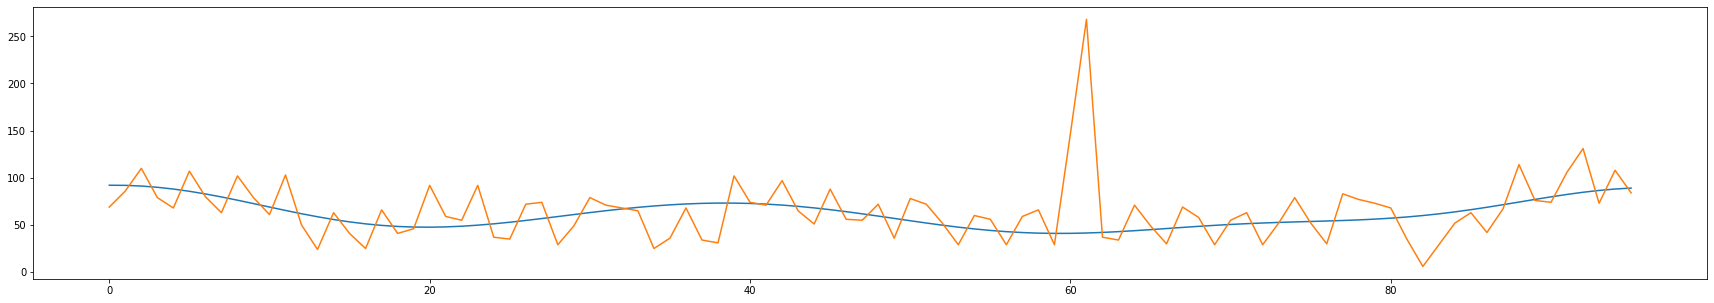

In [44]:
generate(2)

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


MAE (3 days learning): 126.89714
MAE (day before): 87.48958


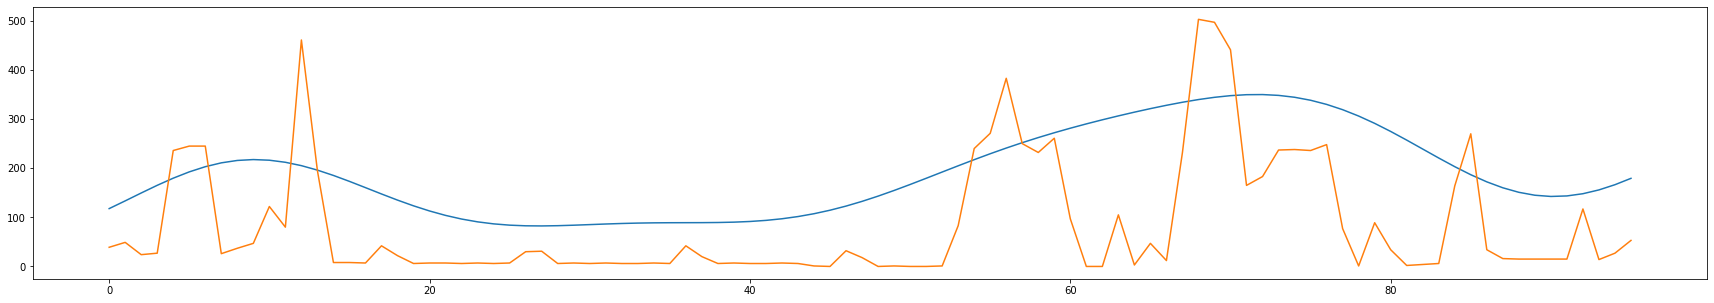

In [45]:
generate(6)

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


MAE (3 days learning): 67.44663
MAE (day before): 65.00000


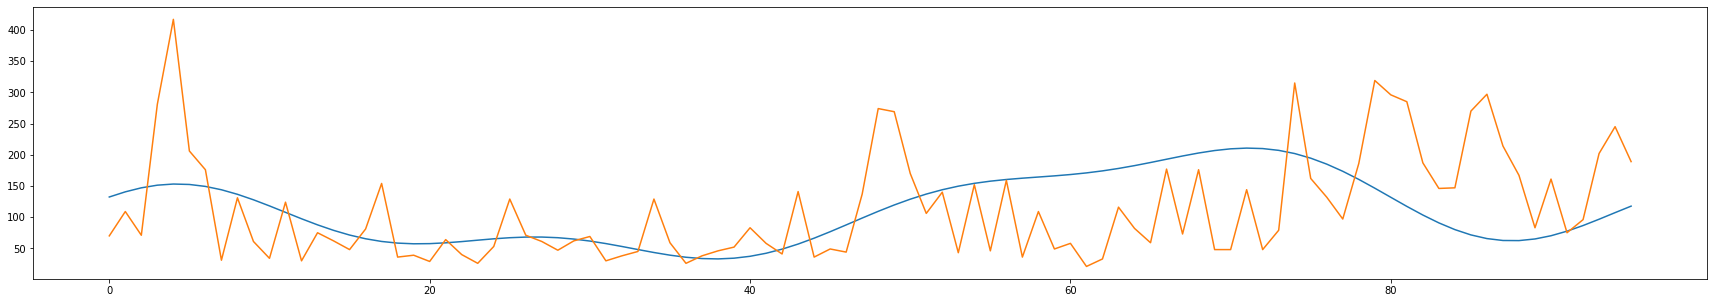

In [46]:
generate(9)

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


MAE (3 days learning): 24.08553
MAE (day before): 27.87500


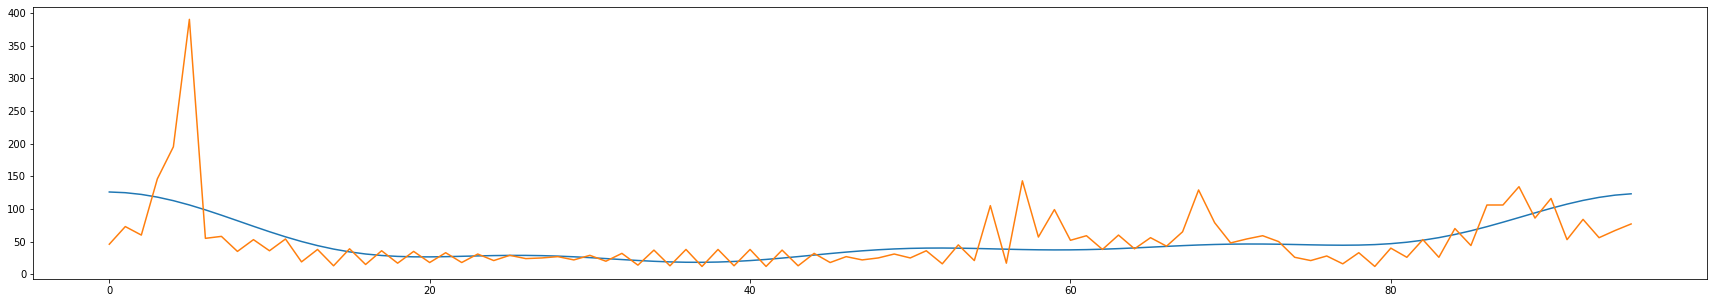

In [47]:
generate(15)

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


MAE (3 days learning): 13.37362
MAE (day before): 29.72917


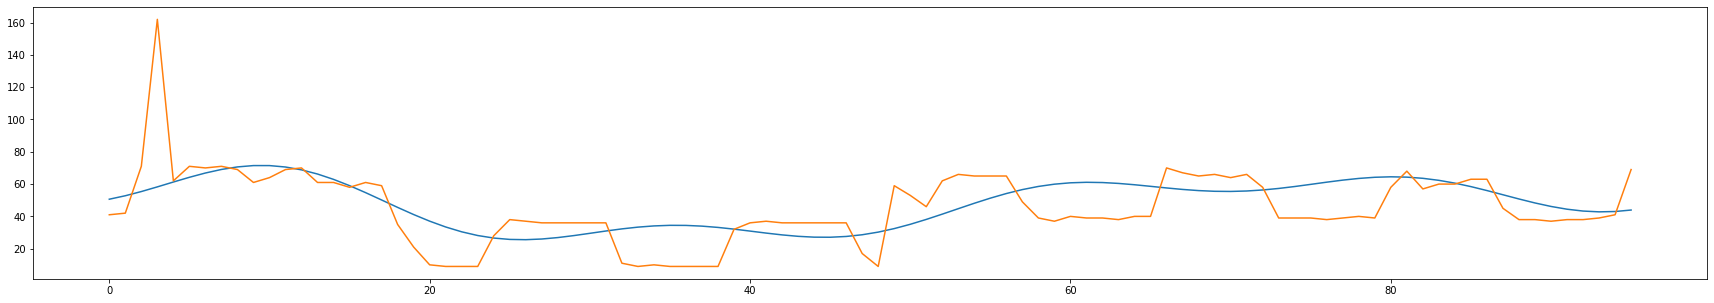

In [48]:
generate(16)


INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


MAE (3 days learning): 52.09116
MAE (day before): 28.30208


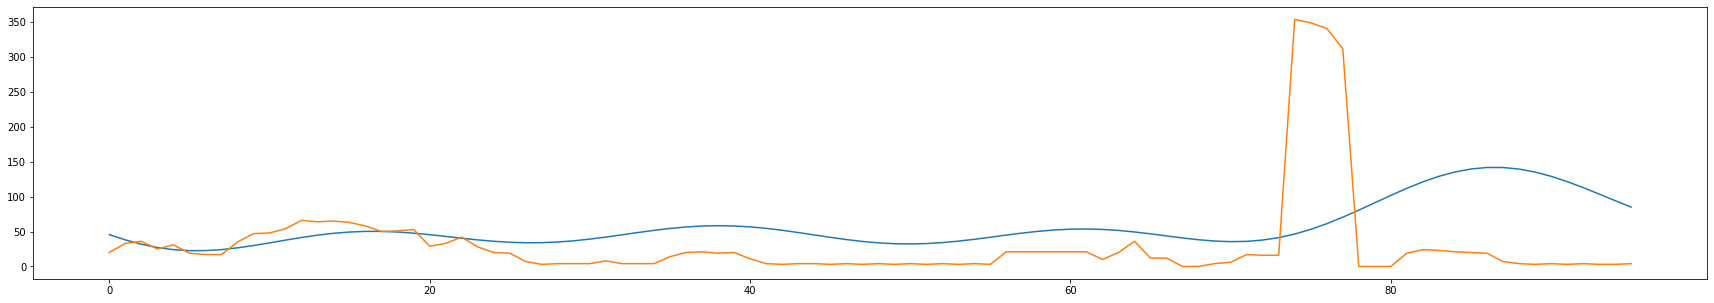

In [49]:
generate(17)


INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


MAE (3 days learning): 66.81742
MAE (day before): 81.90625


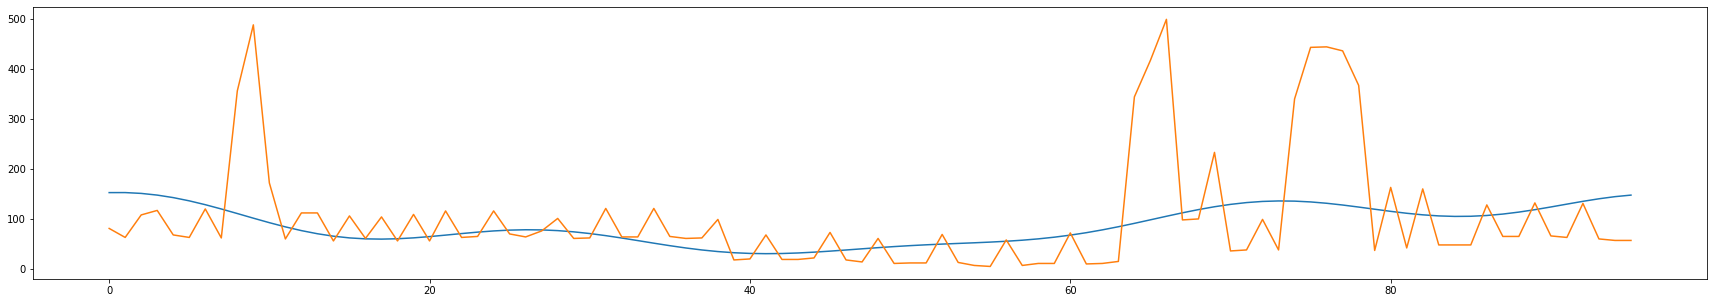

In [50]:
generate(18)


In [51]:
def secondsToString(x):
    m, s = divmod(x, 60)
    h, m = divmod(m, 60)
    return f'{h:d}:{m:02d}'

In [52]:
def plot_grid(ids):
    total = None
    baseline = None
    for id in ids:
        df = pd.read_csv(SCENARIO_FOLDER + "/background/" + str(year) +
                "/" + f'{month:02d}' + "/" + str(id) + ".csv")
        dfbase = pd.read_csv(SCENARIO_FOLDER + "/baseline/" + str(year) +
                "/" + f'{month:02d}' + "/" + str(id) + ".csv")
        background = []
        for i in df[df.columns[1]]:
            background = np.concatenate((background, np.ones(15 * 60) * i))
        if total is None:
            total = background
        else:
            total += background
        line = []
        for i in dfbase[dfbase.columns[1]]:
            line = np.concatenate((line, np.ones(15 * 60) * i))
        if baseline is None:
            baseline = line
        else:
            baseline += line
        config = json.load(open('scenario/' + id + '/config.json'))
        for task in config['tasks']:
            neg = 1
            try:
                file = 'appliances/' + task['category'] + '/' + task['appliance'] + '/' + task['program'] + '/' + os.listdir(
                    'appliances/' + task['category'] + '/' + task['appliance'] + '/' + task['program'] + '/')[0]
            except:
                file = 'appliances/' + \
                    task['category'] + '/' + task['appliance'] + '/' + \
                    str(year - 1) + f'{month:02}' + f'{day:02}' + ".csv"
                neg = -1
            try:
                df = pd.read_csv(file)
                if 'timestamp' in df.columns:
                    df['timestamp'] = pd.to_datetime(df['timestamp'])
                    df = df.set_index('timestamp')
                    df = df.resample('1S').ffill()
                arr = np.concatenate(
                    (np.zeros(task['offset']), df['value'].values))
                arr = np.concatenate((arr, np.zeros(86400 - len(arr))))
                total += arr * neg
            except:
                for p in config["setup"][task["category"]][task["appliance"]]:
                    if p["programName"] == task['program']:
                        if p['duration'] == -1:
                            consume = p["averagePower"] * np.ones(3600 * 24)
                        else:
                            consume = p["averagePower"] * \
                                np.ones(p['duration'])
                            arr = np.concatenate(
                                (np.zeros(task['offset']), consume))
                            arr = np.concatenate(
                                (arr, np.zeros(86400 - len(arr))))
                        total += consume * neg
    time = [secondsToString(x) for x in range(0, 86400)]
    plt.figure(figsize=(30, 10))
    plt.xticks(ticks=range(0, 25*60, 60), labels=['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00',
               '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00', '23:59'])
    plt.plot(time, total, label='Total')
    plt.plot(time, baseline, label='Baseline')
    plt.legend()
    plt.ylabel('Power (W)')
    plt.title("Grid consumption compared to baseline")
    plt.show()
    plt.figure(figsize=(30, 10))
    plt.xticks(ticks=range(0, 25*60, 60), labels=['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00',
               '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00', '23:59'])
    plt.plot(time, total - baseline, label='Imbalance')
    plt.legend()
    plt.ylabel('Power (W)')
    plt.title("Grid imbalance")
    print("Accumulated imbalance: (kWh)",
          (abs(total - baseline)).sum() / (1000 * 3600))
    print("Peak to average power ratio: (dB)", 10 *
          math.log10(total.max() / total.mean()))


plot_grid(["1", "2", "6"])


UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('float64'), dtype('<U19')) -> None